The purpose of this notebok is to build an NLP model to make rading easier medical abstracts easier

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29448e21-ce57-c575-33a1-c8f33021e728)


## Get data

Since we'll be replicating the paper (PUBMED200k) let's downlaod the dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.22 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k_RCT dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k datasets with numbers replace by @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all of the filenames in the target dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [ ]:
# create a function to read lines of a document
def get_lines(filename):
  """
  Read filename and return the lines of text as a list
  """
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Doing preprocessing 

`{'line_number': 9,
  'target': 'RESULTS',
  'text': 'these differences remained significant at @ weeks .',
  'total_lines': 11}`

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Return a list of dictionaries of absatrct line data
  """
  input_lines = get_lines(filename)
  abstract_lines = "" #create an empty abstract
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check if it is `\n`
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["line_number"] = abstract_line_number
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:11]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

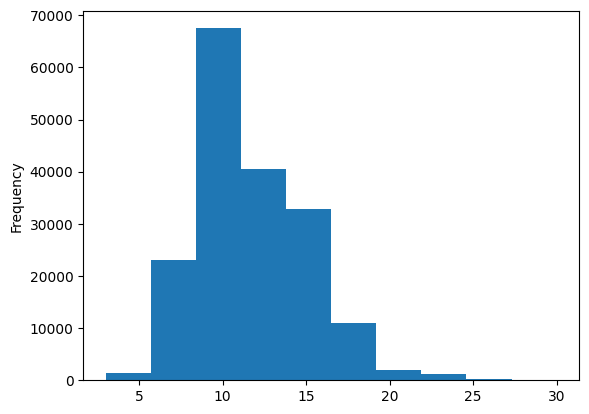

In [ ]:
# Let's chk the length of different lines
train_df.total_lines.plot.hist()

###Get lists of sentences

In [ ]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) #we want non-sparse matrix so sparse=False
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Label encode lables

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0 : Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences,
                 val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

#get helper function 

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-03-31 04:07:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-31 04:07:34 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data text for deep sequence models

* creating textVectorizer and embedding

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#How long is each sentence on average
sen_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sen_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

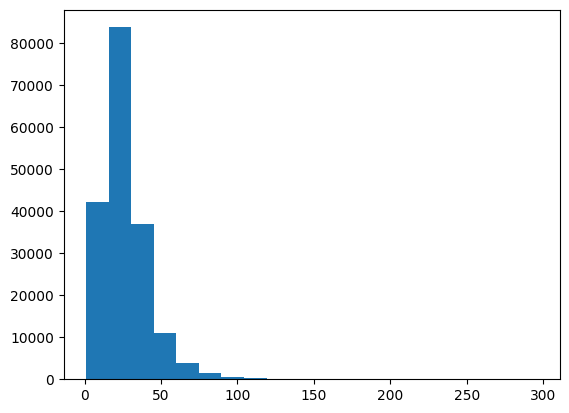

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sen_lens, bins=20)

In [ ]:
#How long of a sentence covers 95% of examples ?
output_seq_len = int(np.percentile(sen_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sen_lens)

296

### Create Text Vectorizer layer


In [ ]:
# How many words are in our vocab (this is taken from table 2 of paper)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapat text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"length of text : {len(target_sentence.split())}")
print(f"\nvectorizer text : {text_vectorizer([target_sentence])}")

Text:
treatment failure from adverse events or tolerability was not different by treatment arm ( p = @ ) .
length of text : 19

vectorizer text : [[ 19 292  27 118 124  16 833  10  31 197  22  19 207  14   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [ ]:
# How many words in our traning vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"total number of words : {len(rct_20k_text_vocab)}")
print(f"Most common words : {rct_20k_text_vocab[:5]}")
print(f"Least common words : {rct_20k_text_vocab[-5:]}")


total number of words : 64841
Most common words : ['', '[UNK]', 'the', 'and', 'of']
Least common words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# Show an example embedding
print(f"Before Vectorization : \n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"After Vectorizer (Before Embedding) \n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"After Embedding \n: {embedded_sentence}")
print(f"Embedded sentence length : {embedded_sentence.shape}")


Before Vectorization : 
 treatment failure from adverse events or tolerability was not different by treatment arm ( p = @ ) .
After Vectorizer (Before Embedding) 
 [[ 19 292  27 118 124  16 833  10  31 197  22  19 207  14   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
After Embedding 
: [[[ 0.01972319 -0.04877697 -0.02402574 ...  0.04269073  0.03082332
    0.00211072]
  [-0.03161956  0.02032897 -0.01030347 ...  0.00375592 -0.01146314
    0.01986631]
  [ 0.01974345 -0.03830808 -0.00719984 ... -0.01129926  0.00220641
    0.00362075]
  ...
  [-0.00012274 -0.03828748  0.00815233 ...  0.01703595  0.04916267
    0.04823795]
  [-0.00012274 -0.03828748  0.00815233 ...  0.01703595  0.04916267
    0.04823795]
  [-0.00012274 -0.03828748  0.00815233 ...  0.01703595  0.04916267
    0.04823795]]]
Embedded sentence length : (1, 55, 128)


## Creating datasets (making sure our data loads as fast as can)

We're going to setup our data to run as fast as possible with `tf.data` API

In [ ]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensorSliceDataset's and turn into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 5)                 325 

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))
                                                   )

Epoch 1/3
562/562 [==============================] - 29s 49ms/step - loss: 0.6609 - accuracy: 0.7660 - val_loss: 0.6114 - val_accuracy: 0.7773
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.4950 - accuracy: 0.8270 - val_loss: 0.6013 - val_accuracy: 0.7826
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.4736 - accuracy: 0.8359 - val_loss: 0.5959 - val_accuracy: 0.7812


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5967 - accuracy: 0.7863


[0.5966506600379944, 0.7862769961357117]

In [ ]:
# Make Predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[5.78343391e-01, 1.26401678e-01, 5.07810563e-02, 2.09724993e-01,
         3.47489081e-02],
        [3.95768404e-01, 2.95314729e-01, 1.85836200e-02, 2.83130527e-01,
         7.20266066e-03],
        [8.79510120e-02, 2.19187187e-03, 4.43416415e-04, 9.09411192e-01,
         2.52097470e-06],
        ...,
        [1.04064304e-06, 1.07302672e-04, 2.12373809e-04, 3.04526793e-07,
         9.99678969e-01],
        [8.52248147e-02, 5.43424547e-01, 6.63732588e-02, 7.15198070e-02,
         2.33457655e-01],
        [5.65345921e-02, 8.91231060e-01, 1.50655145e-02, 1.26204873e-02,
         2.45484225e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Covery pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.62769760360122,
 'precision': 0.7838336778910128,
 'recall': 0.7862769760360122,
 'f1': 0.7847971600960977}

## Model 2 : Feature extraction with pretrained token embedding

now use pre trained word embedding 
https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## Building and fitting an NLP feature extraction model usimg pretrained embeddings Tensorflow Hub

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string) #shape=[] coz tf_hub_embedding_layer wants data in list
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="relu")(x)

model_2 = tf.keras.Model(inputs,outputs,name="model_2_USE")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_18 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 19ms/step - loss: nan - accuracy: 0.1189 - val_loss: nan - val_accuracy: 0.1157
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: nan - accuracy: 0.1227 - val_loss: nan - val_accuracy: 0.1157
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: nan - accuracy: 0.1193 - val_loss: nan - val_accuracy: 0.1157


In [ ]:
#Evalute on whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: nan - accuracy: 0.1142


[nan, 0.11415993422269821]

In [ ]:
# Make Predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:
# Covery pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
# Calculate model_1 results
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 11.415993644909307,
 'precision': 0.01303249109006097,
 'recall': 0.11415993644909307,
 'f1': 0.023394291364660705}

## Model 3 : Conv1D with character Embeddings

### Create a character-level tokenizer

In [ ]:
# Make a function to split into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars("this is a boy")

't h i s   i s   a   b o y'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#What's the average charcter length ?
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard charcter
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV tokens('[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length=output_seq_char_len,
                                 name="char_vectorizer")

In [ ]:
#Adapt charcter vectorizer to training charcter
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"total number of char : {len(char_vocab)}")
print(f"Most common char : {char_vocab[:5]}")
print(f"Least common char : {char_vocab[-5:]}")

total number of char : 28
Most common char : ['', '[UNK]', 'e', 't', 'i']
Least common char : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Show an example embedding
random_train_chars = random.choice(train_chars)
print(f"Before Vectorization : \n {random_train_chars}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"After Vectorizer (Before Embedding) \n {vectorized_chars}")
print(f" length : {len(vectorized_chars[0])}")


Before Vectorization : 
 u p   t o   @   %   o f   p a t i e n t s   w i t h   d e p r e s s i o n   a r e   u n r e s p o n s i v e   t o   a t   l e a s t   t w o   t r i a l s   o f   a n t i d e p r e s s a n t   m e d i c a t i o n   a n d   t h u s   h a v e   ` `   t r e a t m e n t - r e s i s t a n t   d e p r e s s i o n   ' '   (   t r d   )   .
After Vectorizer (Before Embedding) 
 [[16 14  3  7  7 17 14  5  3  4  2  6  3  9 20  4  3 13 10  2 14  8  2  9
   9  4  7  6  5  8  2 16  6  8  2  9 14  7  6  9  4 21  2  3  7  5  3 12
   2  5  9  3  3 20  7  3  8  4  5 12  9  7 17  5  6  3  4 10  2 14  8  2
   9  9  5  6  3 15  2 10  4 11  5  3  4  7  6  5  6 10  3 13 16  9 13  5
  21  2  3  8  2  5  3 15  2  6  3  8  2  9  4  9  3  5  6  3 10  2 14  8
   2  9  9  4  7  6  3  8 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

### Creating a character-level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test out char embed layer
random_train_chars = random.choice(train_chars)
print(f"Before Vectorization : \n {random_train_chars}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"After Vectorizer (Before Embedding) \n {vectorized_chars}")
print(f" length : {len(vectorized_chars[0])}")
embeded_chars = char_embed(vectorized_chars)
print(f"\n After Embedded :\n {embeded_chars}")
print(f"\n Length : {embeded_chars.shape}")

Before Vectorization : 
 t o   e v a l u a t e   t h e   e f f e c t s   o f   a   d e x m e d e t o m i d i n e   c o n s t a n t   r a t e   i n f u s i o n   (   c r i   )   a n d   a t r o p i n e   o n   c h a n g e s   i n   g l o b a l   p e r f u s i o n   v a r i a b l e s   i n d u c e d   b y   h e m o r r h a g e   a n d   v o l u m e   r e p l a c e m e n t   (   v r   )   i n   i s o f l u r a n e - a n e s t h e t i z e d   d o g s   .
After Vectorizer (Before Embedding) 
 [[ 3  7  2 21  5 12 16  5  3  2  3 13  2  2 17 17  2 11  3  9  7 17  5 10
   2 24 15  2 10  2  3  7 15  4 10  4  6  2 11  7  6  9  3  5  6  3  8  5
   3  2  4  6 17 16  9  4  7  6 11  8  4  5  6 10  5  3  8  7 14  4  6  2
   7  6 11 13  5  6 18  2  9  4  6 18 12  7 22  5 12 14  2  8 17 16  9  4
   7  6 21  5  8  4  5 22 12  2  9  4  6 10 16 11  2 10 22 19 13  2 15  7
   8  8 13  5 18  2  5  6 10 21  7 12 16 15  2  8  2 14 12  5 11  2 15  2
   6  3 21  8  4  6  4  9  7 17 12 16  8  5  6  2  5  6  2  9  

### Buliding a Conv1D model to fit on character embeddings

In [ ]:
inputs = layers.Input(shape=(1,) ,dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="relu")(x)

model_3 = tf.keras.Model(inputs,outputs, name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#Fit the model on chars only

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 5.9213 - accuracy: 0.2660 - val_loss: 6.0439 - val_accuracy: 0.3344
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 6.0982 - accuracy: 0.3265 - val_loss: 5.9923 - val_accuracy: 0.3298
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 5.9200 - accuracy: 0.3336 - val_loss: 5.9716 - val_accuracy: 0.3298


In [ ]:
# Make prediction on whole datasets
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.29645824, 0.4158106 , 1.0830572 , 0.30740666, 0.        ],
       [0.33169657, 0.45552593, 0.9779869 , 0.36396515, 0.        ],
       [0.35596967, 0.5224733 , 1.1025724 , 0.38904706, 0.        ],
       ...,
       [0.26824382, 0.5192843 , 1.1692793 , 0.29875815, 0.        ],
       [0.28007776, 0.50099057, 1.1291578 , 0.31687608, 0.        ],
       [0.35798275, 0.49406728, 0.8464904 , 0.2210906 , 0.        ]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 2])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded,
                                  model_3_preds)
model_3_results

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 32.98027273930889,
 'precision': 0.10876983899592008,
 'recall': 0.32980272739308886,
 'f1': 0.16358793188693435}

## Model 4 : Combining pretrained token embedding + Characters embedding

1. Create token-level embedding model (similiar `model_1`)
2. Create a character-level model (similiar to `model_3` with a slight modeification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of outputs layers on top of 3 similiar to fig 1 and section 4.2 of paper
5. construct a model takes token and character-level-sequences as input and produce sequnecs label probabilites as ouput

In [ ]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3.  Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct Model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                          outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

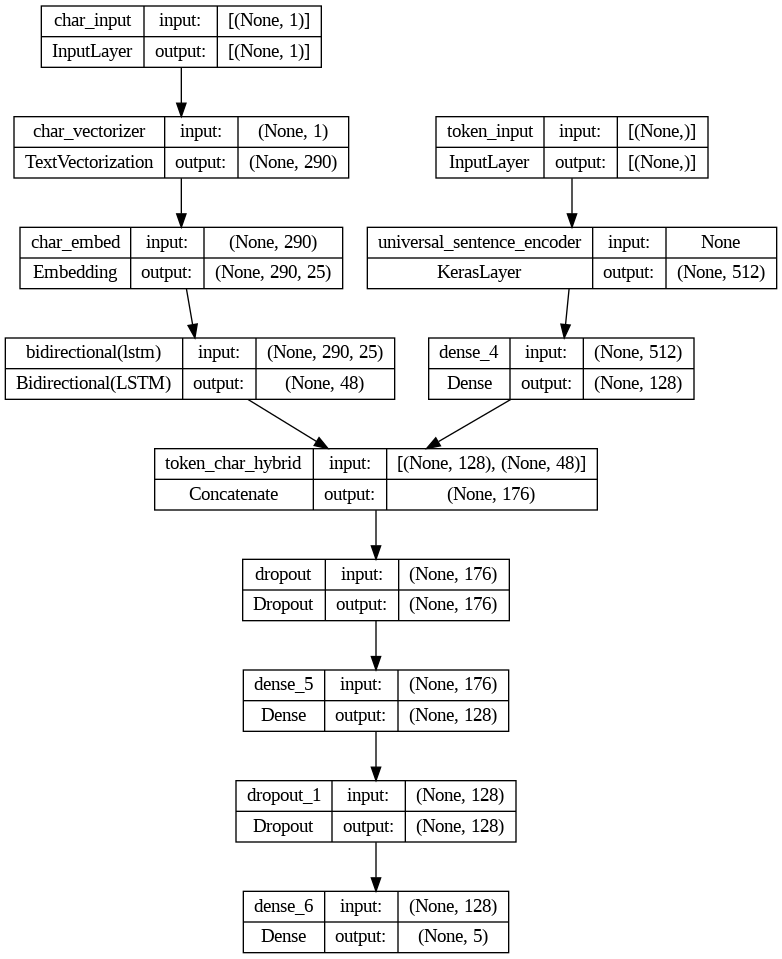

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` Datset

In [ ]:
# combine char and token into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) #same order in how the model created
train_token_char_lables = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_lables))

#Prefetch
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_lables = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_lables))

#Prefetch
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 *len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 *len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 61ms/step - loss: 0.9878 - accuracy: 0.6073 - val_loss: 0.7875 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.8001 - accuracy: 0.6929 - val_loss: 0.7226 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 0.7849 - accuracy: 0.6985 - val_loss: 0.6961 - val_accuracy: 0.7384


In [ ]:
# Evaluate on whole model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6986 - accuracy: 0.7327


[0.6986036896705627, 0.7326558828353882]

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 21ms/step


array([[4.4250971e-01, 3.7656799e-01, 5.8648121e-03, 1.6525091e-01,
        9.8065631e-03],
       [3.9232051e-01, 4.2349258e-01, 3.6946221e-03, 1.7706938e-01,
        3.4229078e-03],
       [2.9638988e-01, 1.6626863e-01, 6.9139779e-02, 4.2976266e-01,
        3.8439013e-02],
       ...,
       [3.7849924e-04, 9.9950060e-03, 5.2690908e-02, 2.2801894e-04,
        9.3670762e-01],
       [6.6388603e-03, 5.6763213e-02, 2.0051289e-01, 4.1115200e-03,
        7.3197353e-01],
       [2.3671904e-01, 3.9312595e-01, 2.6651594e-01, 2.5220759e-02,
        7.8418359e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 73.2655898318549,
 'precision': 0.7322859421985638,
 'recall': 0.7326558983185489,
 'f1': 0.7298001702817885}

## Model 5 : Transfer Learning with pretrained token embedding + character embedding + positional embeddings

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


**NOTE : ** Any engineered used to train a model need to be available at test time. In our case, line numbers are available

### Create Positional Embedding

In [ ]:
#How many differnet line numbers are there ?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

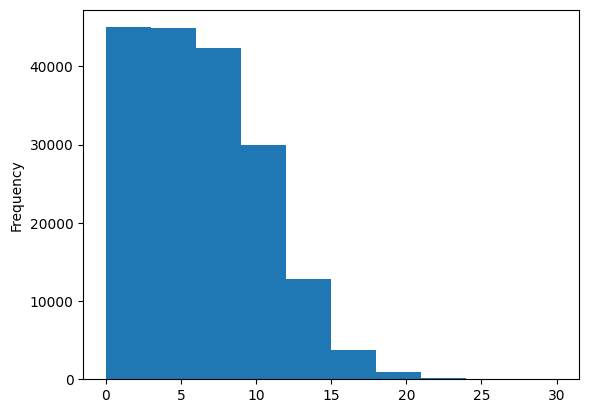

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we have encoded our line features, let's do that total_lines

In [ ]:
# how many different numbers of lines are there ?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

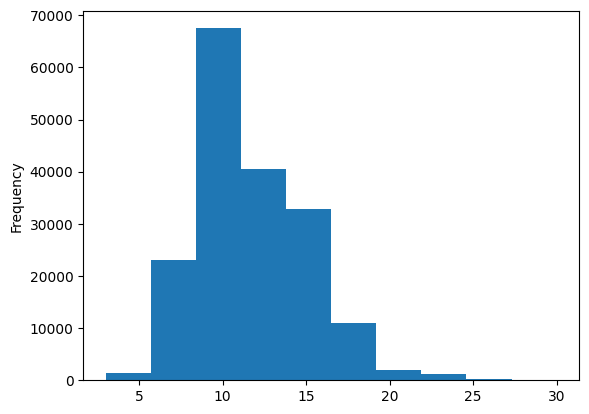

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
# Check the coverage of a "total_lines" vlue of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use Tensorflow to create one_hot_encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

train_total_lines_one_hot[:10],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. create a token level model
2. create a charcter level model
3. create a model for the `line_number` feature
4. create a model for `total_lines` feature
5. Combines the outputs of 1 & 2 using `tf.keras.Concatenate`
6. Combines the outputs of 3,4,5 using `tf.keras.Concatenate`
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

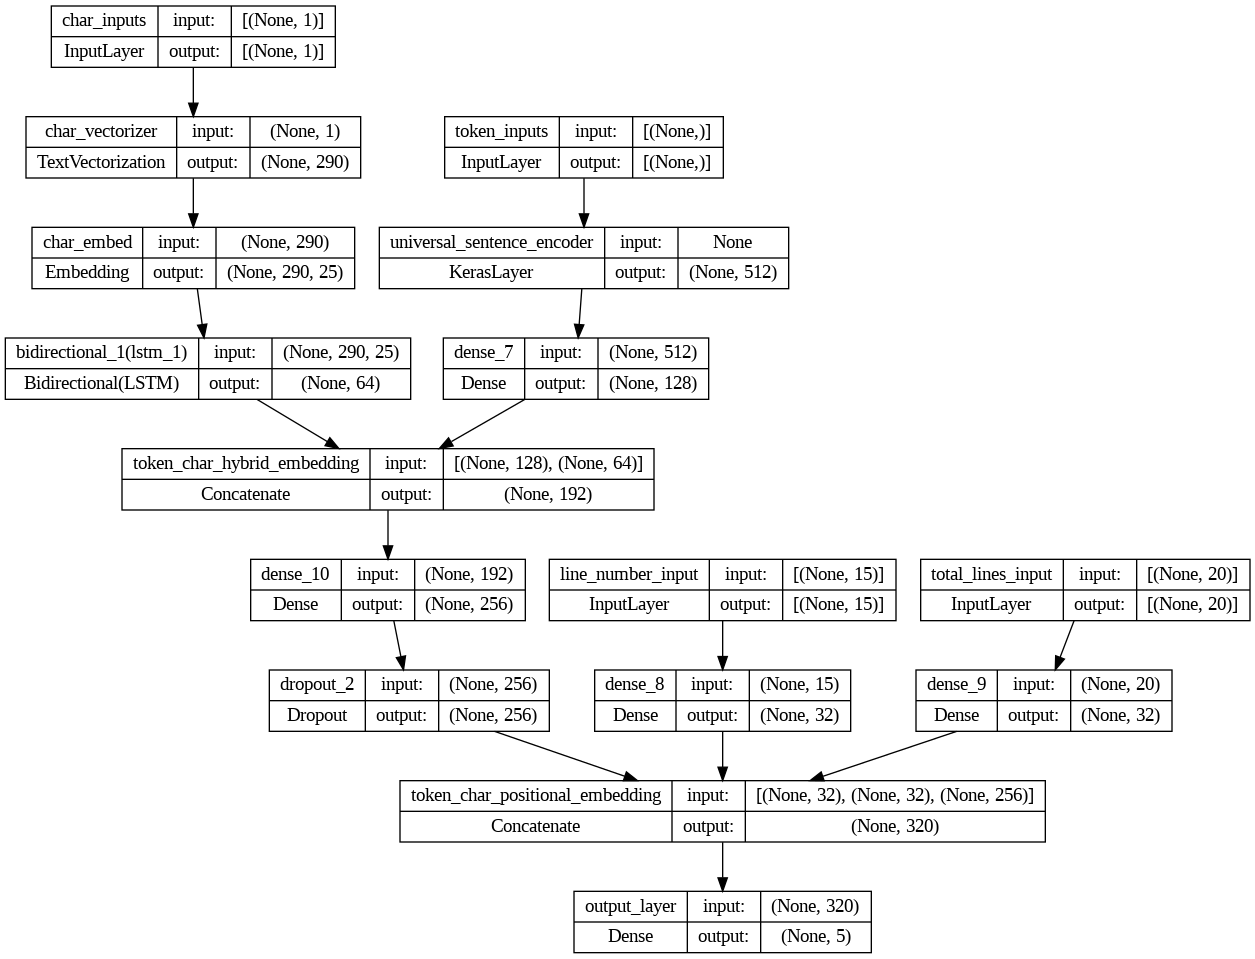

In [ ]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #label_smoothing helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create Tribrid Datasets using `tf.data`

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 59ms/step - loss: 1.0979 - accuracy: 0.7216 - val_loss: 0.9847 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9699 - accuracy: 0.8136 - val_loss: 0.9518 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9515 - accuracy: 0.8216 - val_loss: 0.9387 - val_accuracy: 0.8344


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 36s 33ms/step


array([[0.52296466, 0.09454058, 0.01086872, 0.35717466, 0.01445144],
       [0.5544678 , 0.09430774, 0.03566502, 0.30589393, 0.00966548],
       [0.31210032, 0.1121126 , 0.1462388 , 0.37364426, 0.05590402],
       ...,
       [0.03642013, 0.10270397, 0.05251916, 0.03319997, 0.7751568 ],
       [0.03218727, 0.26193267, 0.08997297, 0.02811352, 0.5877935 ],
       [0.29010218, 0.5145079 , 0.09753055, 0.04258094, 0.0552784 ]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 83.24175824175825,
 'precision': 0.8313285883661712,
 'recall': 0.8324175824175825,
 'f1': 0.8314011397767987}

## Compare results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.621078,0.783135,0.786211,0.783975
pretrained_token_embed,11.415994,0.013032,0.114160,0.023394
custom_char_embed_conv1d,32.980273,0.108770,0.329803,0.163588
hybrid_char_token_embed,73.265590,0.732286,0.732656,0.729800
tribrid_pos_char_token_embed,83.241758,0.831329,0.832418,0.831401


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

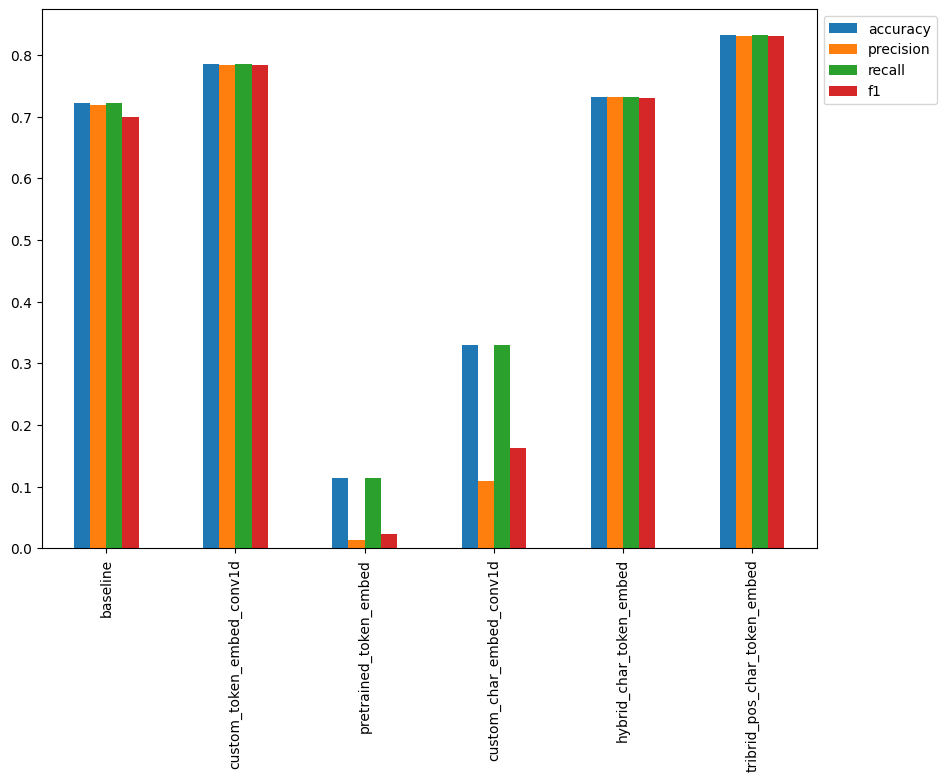

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

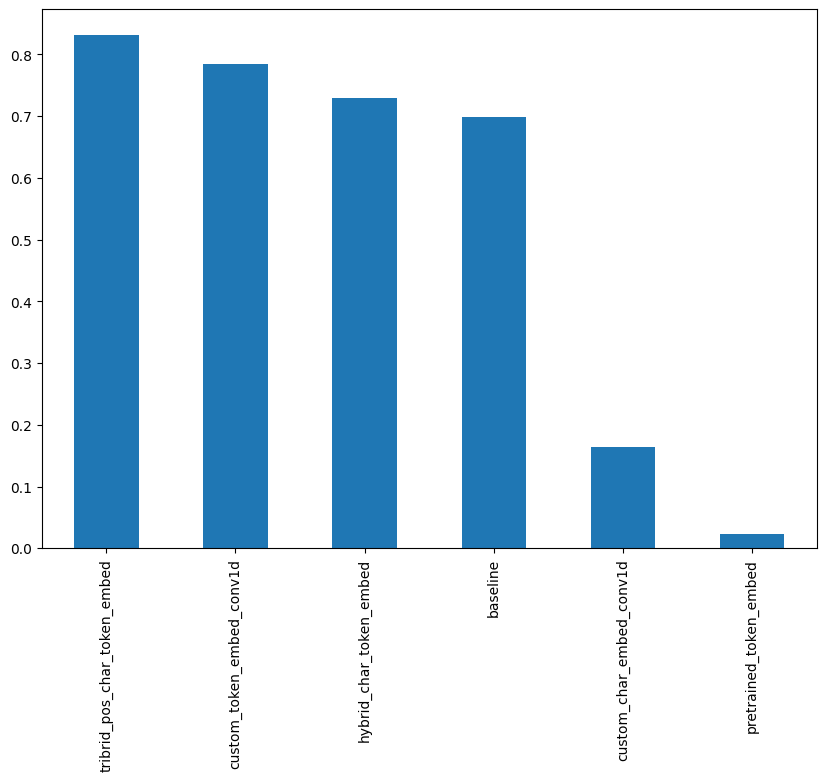

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

#Save and load best performing model

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")